# SGR SAOS: Frequency Sweeps and Phase Classification

**Learning Objectives:**
- Fit SGR models to small-amplitude oscillatory shear (SAOS) data
- Classify material phase regime from noise temperature parameter x
- Visualize power-law scaling G' ~ G'' ~ ω^(x-1)
- Compare SGRConventional and SGRGeneric frameworks
- Perform Bayesian inference with NUTS for parameter uncertainty

**Prerequisites:** Familiarity with oscillatory rheology (G', G'', tan δ)

**Runtime:** ~2-3 minutes (NLSQ + quick Bayesian with 1 chain)

## 1. Setup

In [1]:
# Google Colab setup
import sys

IN_COLAB = "google.colab" in sys.modules
if IN_COLAB:
    %pip install -q rheojax
    import os
    os.environ["JAX_ENABLE_X64"] = "true"
    print("RheoJAX installed successfully.")

In [2]:
%matplotlib inline
import os
import json
import time
import warnings

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display

from rheojax.core.jax_config import safe_import_jax, verify_float64
from rheojax.models.sgr import SGRConventional, SGRGeneric

jax, jnp = safe_import_jax()
verify_float64()

warnings.filterwarnings("ignore", category=FutureWarning)
print(f"JAX version: {jax.__version__}")
print(f"Devices: {jax.devices()}")

JAX version: 0.8.2
Devices: [CpuDevice(id=0)]


In [3]:
def compute_fit_quality(y_true, y_pred):
    """Compute R² and RMSE."""
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    residuals = y_true - y_pred
    if y_true.ndim > 1:
        residuals = residuals.ravel()
        y_true = y_true.ravel()
    ss_res = np.sum(residuals**2)
    ss_tot = np.sum((y_true - np.mean(y_true))**2)
    r2 = 1.0 - ss_res / ss_tot if ss_tot > 0 else 0.0
    rmse = np.sqrt(np.mean(residuals**2))
    return {"R2": r2, "RMSE": rmse}

## 2. Theory: SGR Oscillatory Response

For small-amplitude oscillatory shear (SAOS), the complex modulus is:

$$G^*(\omega) = G'(\omega) + iG''(\omega)$$

SGR predicts power-law scaling in the soft glass regime:

$$G'(\omega) \sim G''(\omega) \sim \omega^{x-1} \quad \text{for } 1 < x < 2$$

**Phase-dependent behavior:**

- **x < 1 (Glass):** $G' \gg G''$, nearly frequency-independent plateau, solid-like
- **1 < x < 2 (Soft Glass):** $G'$ and $G''$ both show power-law frequency dependence, weak gel
- **x ≥ 2 (Newtonian):** $G'' \gg G'$, liquid-like with $G'' \sim \omega$

The noise temperature **x** directly encodes the material phase and can be extracted from the slope of log(G') vs log(ω).

## 3. Load Data

In [4]:
# Load chia seed gel oscillation data
data_path = os.path.join("..", "data", "oscillation", "foods", "oscillation_chia_data.csv")
raw = np.loadtxt(data_path, delimiter=",", skiprows=1)
omega = raw[:, 0]           # Angular frequency [rad/s]
G_prime = raw[:, 1]         # Storage modulus [Pa]
G_double_prime = raw[:, 2]  # Loss modulus [Pa]

# Sort by frequency (ascending) if needed
sort_idx = np.argsort(omega)
omega = omega[sort_idx]
G_prime = G_prime[sort_idx]
G_double_prime = G_double_prime[sort_idx]

G_star = np.column_stack([G_prime, G_double_prime])

print(f"Data points: {len(omega)}")
print(f"Frequency range: {omega.min():.4f} – {omega.max():.1f} rad/s")
print(f"G' range: {G_prime.min():.1f} – {G_prime.max():.1f} Pa")
print(f"G'' range: {G_double_prime.min():.1f} – {G_double_prime.max():.1f} Pa")

Data points: 25
Frequency range: 0.0073 – 100.0 rad/s
G' range: 36.2 – 178.1 Pa
G'' range: 9.2 – 228.5 Pa


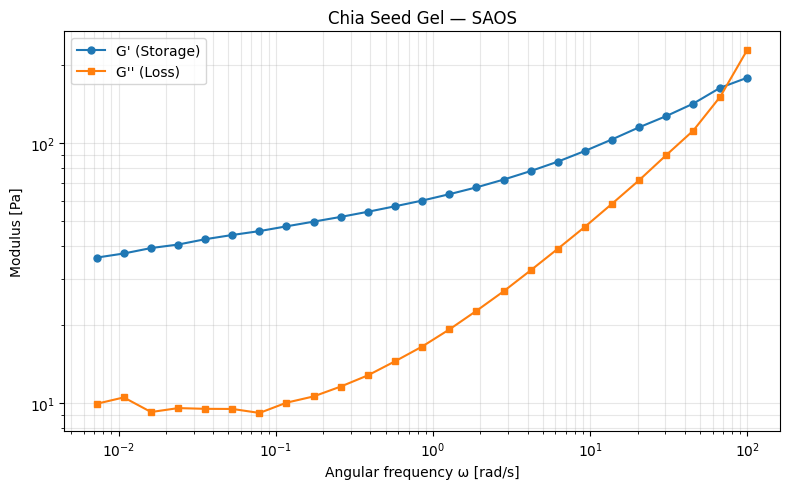

In [5]:
# Plot raw data
fig, ax = plt.subplots(figsize=(8, 5))
ax.loglog(omega, G_prime, "o-", markersize=5, label="G' (Storage)")
ax.loglog(omega, G_double_prime, "s-", markersize=5, label="G'' (Loss)")
ax.set_xlabel("Angular frequency ω [rad/s]")
ax.set_ylabel("Modulus [Pa]")
ax.set_title("Chia Seed Gel — SAOS")
ax.legend()
ax.grid(True, alpha=0.3, which="both")
plt.tight_layout()
display(fig)
plt.close(fig)

## 4. NLSQ Fitting

### 4.1 Fit to Chia Seed Gel

In [6]:
# NLSQ fit with SGRConventional
model = SGRConventional()

t0 = time.time()
model.fit(omega, G_star, test_mode="oscillation", method='scipy')
t_nlsq = time.time() - t0

# Compute fit quality
G_pred_fit = model.predict(omega)
metrics = compute_fit_quality(G_star, G_pred_fit)

print(f"NLSQ fit time: {t_nlsq:.2f} s")
print(f"R²: {metrics['R2']:.6f}")
print(f"RMSE: {metrics['RMSE']:.4g} Pa")
print("\nFitted parameters:")
for name in ["x", "G0", "tau0"]:
    val = model.parameters.get_value(name)
    print(f"  {name:5s} = {val:.4g}")
print(f"Phase regime: {model.get_phase_regime()}")

INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=3 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=2.864721s


INFO:nlsq.least_squares:Convergence reason=`ftol` termination condition is satisfied. | iterations=28 | final_cost=1.0558 | elapsed=2.865s | final_gradient_norm=32.8760


NLSQ fit time: 4.64 s
R²: -0.034745
RMSE: 50.37 Pa

Fitted parameters:
  x     = 0.5
  G0    = 90.88
  tau0  = 590.1
Phase regime: glass


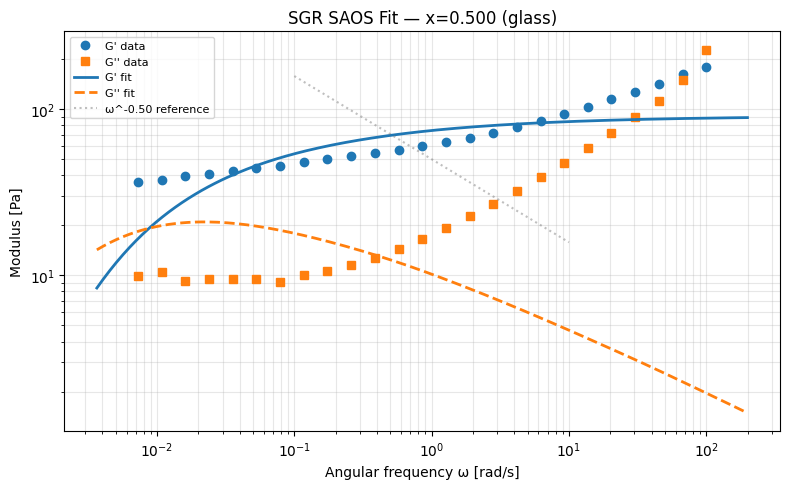

In [7]:
# Plot fit with power-law reference
omega_fine = np.logspace(np.log10(omega.min()) - 0.3, np.log10(omega.max()) + 0.3, 200)
G_pred = model.predict(omega_fine)

fig, ax = plt.subplots(figsize=(8, 5))
ax.loglog(omega, G_prime, "o", markersize=6, color="C0", label="G' data")
ax.loglog(omega, G_double_prime, "s", markersize=6, color="C1", label="G'' data")
ax.loglog(omega_fine, G_pred[:, 0], "-", lw=2, color="C0", label="G' fit")
ax.loglog(omega_fine, G_pred[:, 1], "--", lw=2, color="C1", label="G'' fit")

# Power-law reference
x_fit = model.parameters.get_value("x")
slope = x_fit - 1
ref_omega = np.logspace(-1, 1, 50)
ref_G = 50 * ref_omega ** slope
ax.loglog(ref_omega, ref_G, ":", lw=1.5, color="gray", alpha=0.5, label=f"ω^{slope:.2f} reference")

ax.set_xlabel("Angular frequency ω [rad/s]")
ax.set_ylabel("Modulus [Pa]")
ax.set_title(f"SGR SAOS Fit — x={x_fit:.3f} ({model.get_phase_regime()})")
ax.legend(fontsize=8)
ax.grid(True, alpha=0.3, which="both")
plt.tight_layout()
display(fig)
plt.close(fig)

### 4.2 Phase Regime Exploration

Explore how G'(ω) and G''(ω) change across SGR phase regimes by predicting for different x values.

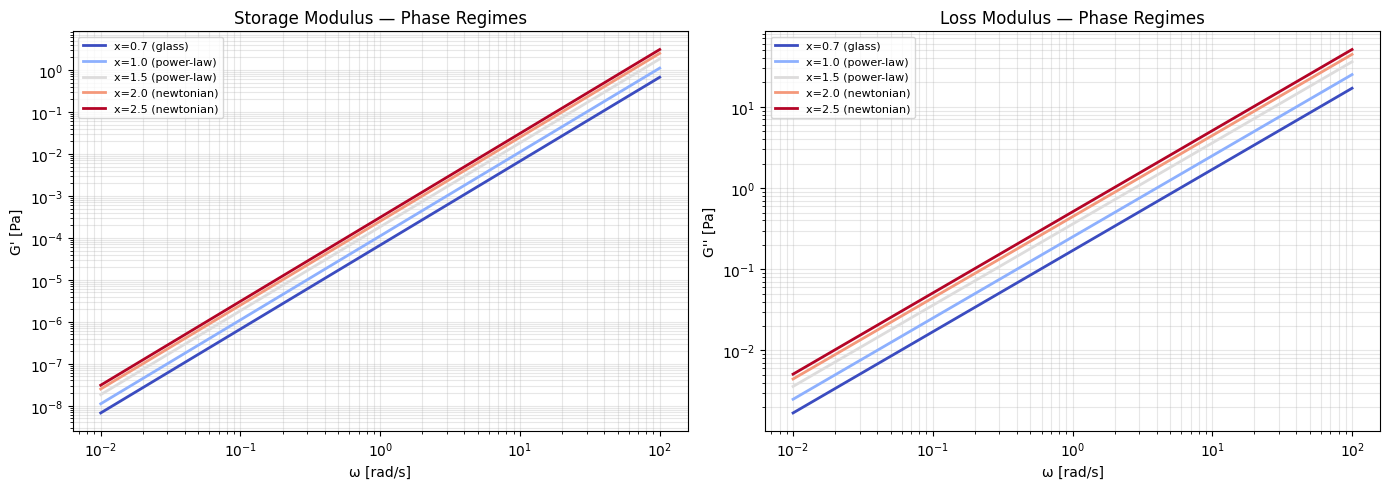

In [8]:
# Phase sweep predictions
x_values = [0.7, 1.0, 1.5, 2.0, 2.5]
omega_sweep = np.logspace(-2, 2, 200)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
colors = plt.cm.coolwarm(np.linspace(0, 1, len(x_values)))

for i, x_val in enumerate(x_values):
    m = SGRConventional()
    m.parameters.set_value("x", x_val)
    m.parameters.set_value("G0", 1000.0)
    m.parameters.set_value("tau0", 1e-3)
    m.fitted_ = True
    m._test_mode = "oscillation"
    
    G_sweep = m.predict(omega_sweep)
    regime = m.get_phase_regime()
    
    ax1.loglog(omega_sweep, G_sweep[:, 0], "-", color=colors[i], lw=2, label=f"x={x_val} ({regime})")
    ax2.loglog(omega_sweep, G_sweep[:, 1], "-", color=colors[i], lw=2, label=f"x={x_val} ({regime})")

ax1.set_xlabel("ω [rad/s]")
ax1.set_ylabel("G' [Pa]")
ax1.set_title("Storage Modulus — Phase Regimes")
ax1.legend(fontsize=8)
ax1.grid(True, alpha=0.3, which="both")

ax2.set_xlabel("ω [rad/s]")
ax2.set_ylabel("G'' [Pa]")
ax2.set_title("Loss Modulus — Phase Regimes")
ax2.legend(fontsize=8)
ax2.grid(True, alpha=0.3, which="both")

plt.tight_layout()
display(fig)
plt.close(fig)

### 4.3 Material Classification Guide

| x Range | Phase | G' vs G'' | Material Examples |
|---------|-------|-----------|-------------------|
| x < 1 | Glass | G' >> G'', plateau | Dense pastes, aged gels |
| 1 < x < 1.5 | Soft glass | G' > G'', weak ω-dep | Foams, emulsions |
| 1.5 < x < 2 | Power-law | G' ~ G'' | Polymer solutions |
| x ≥ 2 | Newtonian | G'' >> G' | Simple liquids |

### 4.4 Cole-Cole Plot

The Cole-Cole plot (G' vs G'') provides a phase-space view of the viscoelastic response.

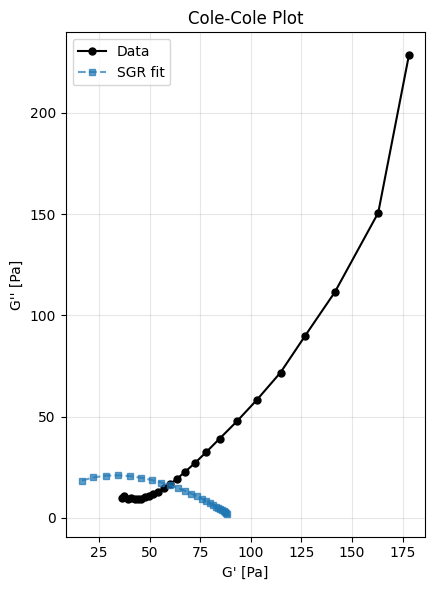

In [9]:
# Cole-Cole plot
fig, ax = plt.subplots(figsize=(7, 6))
ax.plot(G_prime, G_double_prime, "ko-", markersize=5, label="Data")

G_pred_data = model.predict(omega)
ax.plot(G_pred_data[:, 0], G_pred_data[:, 1], "s--", markersize=4, color="C0", alpha=0.7, label="SGR fit")

ax.set_xlabel("G' [Pa]")
ax.set_ylabel("G'' [Pa]")
ax.set_title("Cole-Cole Plot")
ax.set_aspect("equal")
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
display(fig)
plt.close(fig)

### 4.5 SGRGeneric Comparison

Compare SGRConventional with SGRGeneric (GENERIC framework with thermodynamic consistency).

INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=3 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=0.494556s


INFO:nlsq.least_squares:Convergence reason=`ftol` termination condition is satisfied. | iterations=28 | final_cost=1.0558 | elapsed=0.495s | final_gradient_norm=32.8760


SGRConventional vs SGRGeneric:
  Conventional: x=0.5000, R²=-0.034745
  Generic:      x=0.5000, R²=-0.034745

Thermodynamic consistency: True


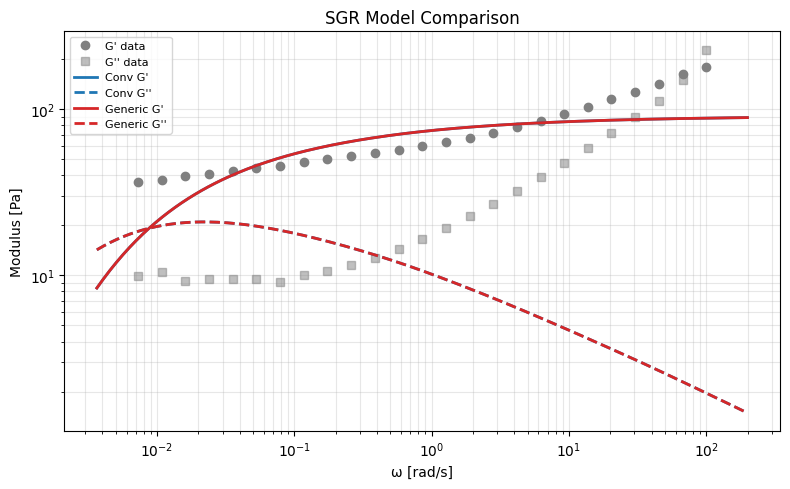

In [10]:
# SGRGeneric comparison
model_gen = SGRGeneric()
model_gen.fit(omega, G_star, test_mode="oscillation", method='scipy')

# Compute fit quality for both models
G_conv_fit = model.predict(omega)
G_gen_fit = model_gen.predict(omega)
metrics_conv = compute_fit_quality(G_star, G_conv_fit)
metrics_gen = compute_fit_quality(G_star, G_gen_fit)

print("SGRConventional vs SGRGeneric:")
print(f"  Conventional: x={model.parameters.get_value('x'):.4f}, R²={metrics_conv['R2']:.6f}")
print(f"  Generic:      x={model_gen.parameters.get_value('x'):.4f}, R²={metrics_gen['R2']:.6f}")

state = np.array([100.0, 0.5])
consistency = model_gen.verify_thermodynamic_consistency(state)
print(f"\nThermodynamic consistency: {consistency.get('thermodynamically_consistent', 'N/A')}")

G_gen_pred = model_gen.predict(omega_fine)

fig, ax = plt.subplots(figsize=(8, 5))
ax.loglog(omega, G_prime, "o", markersize=6, color="gray", label="G' data")
ax.loglog(omega, G_double_prime, "s", markersize=6, color="gray", alpha=0.5, label="G'' data")
ax.loglog(omega_fine, G_pred[:, 0], "-", lw=2, color="C0", label="Conv G'")
ax.loglog(omega_fine, G_pred[:, 1], "--", lw=2, color="C0", label="Conv G''")
ax.loglog(omega_fine, G_gen_pred[:, 0], "-", lw=2, color="C3", label="Generic G'")
ax.loglog(omega_fine, G_gen_pred[:, 1], "--", lw=2, color="C3", label="Generic G''")
ax.set_xlabel("ω [rad/s]")
ax.set_ylabel("Modulus [Pa]")
ax.set_title("SGR Model Comparison")
ax.legend(fontsize=8)
ax.grid(True, alpha=0.3, which="both")
plt.tight_layout()
display(fig)
plt.close(fig)

## 5. Bayesian Inference with NUTS

### 5.1 Run NUTS

Use NLSQ parameters as warm-start for Bayesian inference.

In [11]:
# Bayesian inference
initial_values = {name: model.parameters.get_value(name) for name in ["x", "G0", "tau0"]}
print("Warm-start values:", initial_values)

NUM_WARMUP = 200
NUM_SAMPLES = 500
NUM_CHAINS = 1
# NUM_WARMUP = 1000; NUM_SAMPLES = 2000; NUM_CHAINS = 4  # production

t0 = time.time()
result = model.fit_bayesian(
    omega, G_star, test_mode="oscillation",
    num_warmup=NUM_WARMUP, num_samples=NUM_SAMPLES, num_chains=NUM_CHAINS,
    initial_values=initial_values, seed=42,
)
t_bayes = time.time() - t0
print(f"\nBayesian inference time: {t_bayes:.1f} s")

Warm-start values: {'x': 0.5000000000046292, 'G0': 90.88021351925138, 'tau0': 590.0696565731527}


  0%|          | 0/700 [00:00<?, ?it/s]

warmup:   0%|          | 1/700 [00:00<05:40,  2.05it/s, 1 steps of size 1.65e+00. acc. prob=0.00]

warmup:   4%|▍         | 27/700 [00:00<00:12, 52.72it/s, 1023 steps of size 4.66e-03. acc. prob=0.89]

warmup:   5%|▌         | 37/700 [00:01<00:17, 38.60it/s, 127 steps of size 1.08e-02. acc. prob=0.92] 

warmup:   6%|▋         | 44/700 [00:01<00:15, 41.25it/s, 175 steps of size 1.81e-02. acc. prob=0.93]

warmup:   7%|▋         | 50/700 [00:01<00:15, 42.28it/s, 47 steps of size 2.51e-02. acc. prob=0.94] 

warmup:   9%|▉         | 65/700 [00:01<00:10, 62.97it/s, 39 steps of size 4.43e-02. acc. prob=0.95]

warmup:  13%|█▎        | 93/700 [00:01<00:05, 109.32it/s, 95 steps of size 5.04e-02. acc. prob=0.96]

warmup:  16%|█▌        | 113/700 [00:01<00:04, 129.37it/s, 127 steps of size 2.77e-02. acc. prob=0.96]

warmup:  19%|█▊        | 130/700 [00:01<00:04, 137.44it/s, 47 steps of size 5.32e-02. acc. prob=0.96] 

warmup:  23%|██▎       | 158/700 [00:01<00:03, 171.39it/s, 127 steps of size 3.95e-02. acc. prob=0.96]

warmup:  25%|██▌       | 178/700 [00:01<00:02, 175.07it/s, 31 steps of size 6.86e-02. acc. prob=0.96] 

sample:  29%|██▉       | 206/700 [00:02<00:02, 203.52it/s, 63 steps of size 8.68e-02. acc. prob=0.99]

sample:  34%|███▍      | 238/700 [00:02<00:01, 235.57it/s, 31 steps of size 8.68e-02. acc. prob=0.99]

sample:  38%|███▊      | 263/700 [00:02<00:01, 238.78it/s, 31 steps of size 8.68e-02. acc. prob=0.99]

sample:  41%|████      | 288/700 [00:02<00:02, 171.52it/s, 23 steps of size 8.68e-02. acc. prob=0.99]

sample:  44%|████▍     | 309/700 [00:02<00:02, 161.54it/s, 55 steps of size 8.68e-02. acc. prob=0.99]

sample:  47%|████▋     | 329/700 [00:02<00:02, 165.65it/s, 63 steps of size 8.68e-02. acc. prob=0.99]

sample:  50%|████▉     | 349/700 [00:02<00:02, 172.86it/s, 63 steps of size 8.68e-02. acc. prob=0.99]

sample:  54%|█████▍    | 377/700 [00:02<00:01, 199.52it/s, 39 steps of size 8.68e-02. acc. prob=0.99]

sample:  57%|█████▋    | 399/700 [00:03<00:01, 173.48it/s, 59 steps of size 8.68e-02. acc. prob=0.99]

sample:  61%|██████    | 424/700 [00:03<00:01, 190.25it/s, 63 steps of size 8.68e-02. acc. prob=0.99]

sample:  64%|██████▎   | 445/700 [00:03<00:01, 186.34it/s, 15 steps of size 8.68e-02. acc. prob=0.99]

sample:  67%|██████▋   | 470/700 [00:03<00:01, 199.10it/s, 63 steps of size 8.68e-02. acc. prob=0.99]

sample:  72%|███████▏  | 501/700 [00:03<00:00, 227.85it/s, 63 steps of size 8.68e-02. acc. prob=0.99]

sample:  75%|███████▌  | 525/700 [00:03<00:00, 187.47it/s, 63 steps of size 8.68e-02. acc. prob=0.99]

sample:  78%|███████▊  | 546/700 [00:03<00:00, 188.75it/s, 31 steps of size 8.68e-02. acc. prob=0.99]

sample:  81%|████████▏ | 570/700 [00:03<00:00, 199.54it/s, 63 steps of size 8.68e-02. acc. prob=0.99]

sample:  87%|████████▋ | 606/700 [00:04<00:00, 240.78it/s, 63 steps of size 8.68e-02. acc. prob=0.99]

sample:  90%|█████████ | 633/700 [00:04<00:00, 247.84it/s, 31 steps of size 8.68e-02. acc. prob=0.99]

sample:  94%|█████████▍| 659/700 [00:04<00:00, 227.94it/s, 31 steps of size 8.68e-02. acc. prob=0.99]

sample:  98%|█████████▊| 683/700 [00:04<00:00, 224.98it/s, 31 steps of size 8.68e-02. acc. prob=0.99]

sample: 100%|██████████| 700/700 [00:04<00:00, 156.65it/s, 15 steps of size 8.68e-02. acc. prob=0.99]


Bayesian inference time: 8.1 s


### 5.2 Convergence Diagnostics

In [12]:
# Convergence diagnostics
diag = result.diagnostics
param_names = ["x", "G0", "tau0"]

print("Convergence Diagnostics")
print("=" * 50)
print(f"{'Parameter':>10s}  {'R-hat':>8s}  {'ESS':>8s}")
print("-" * 50)
for p in param_names:
    r_hat = diag.get("r_hat", {}).get(p, float("nan"))
    ess = diag.get("ess", {}).get(p, float("nan"))
    print(f"{p:>10s}  {r_hat:8.4f}  {ess:8.0f}")
n_div = diag.get("divergences", diag.get("num_divergences", 0))
print(f"\nDivergences: {n_div}")

Convergence Diagnostics
 Parameter     R-hat       ESS
--------------------------------------------------
         x    1.0000       500
        G0    1.0000       500
      tau0    1.0000       500

Divergences: 0


### 5.3 ArviZ Plots

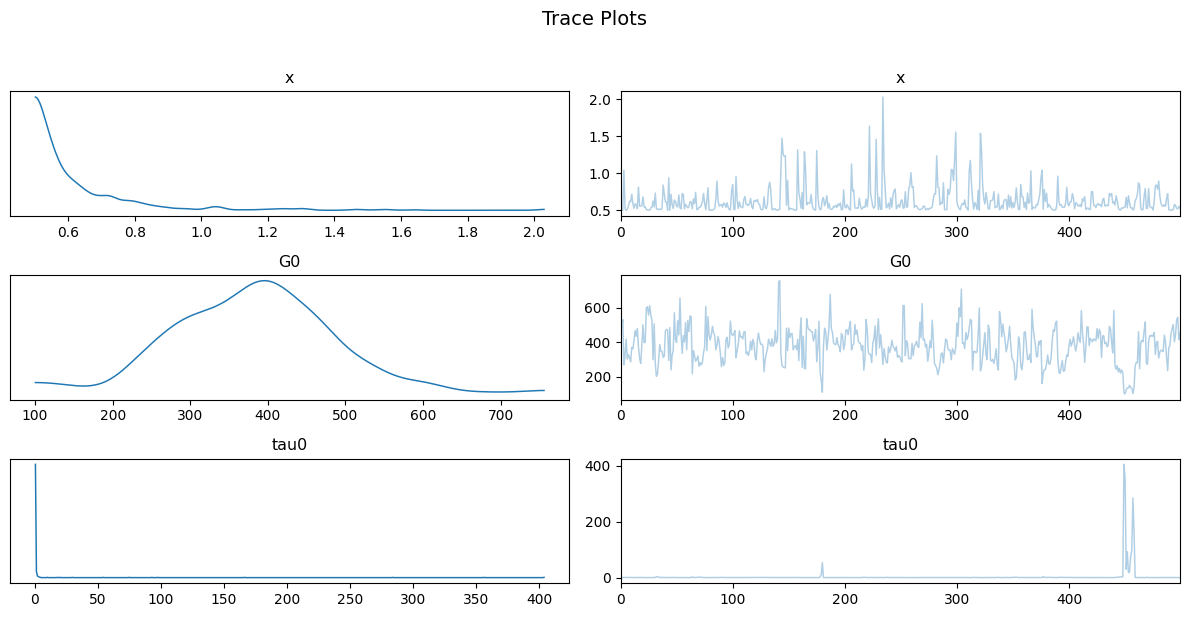

In [13]:
# Trace plots
idata = result.to_inference_data()
axes = az.plot_trace(idata, var_names=param_names, figsize=(12, 6))
fig = axes.ravel()[0].figure
fig.suptitle("Trace Plots", fontsize=14, y=1.02)
plt.tight_layout()
display(fig)
plt.close(fig)

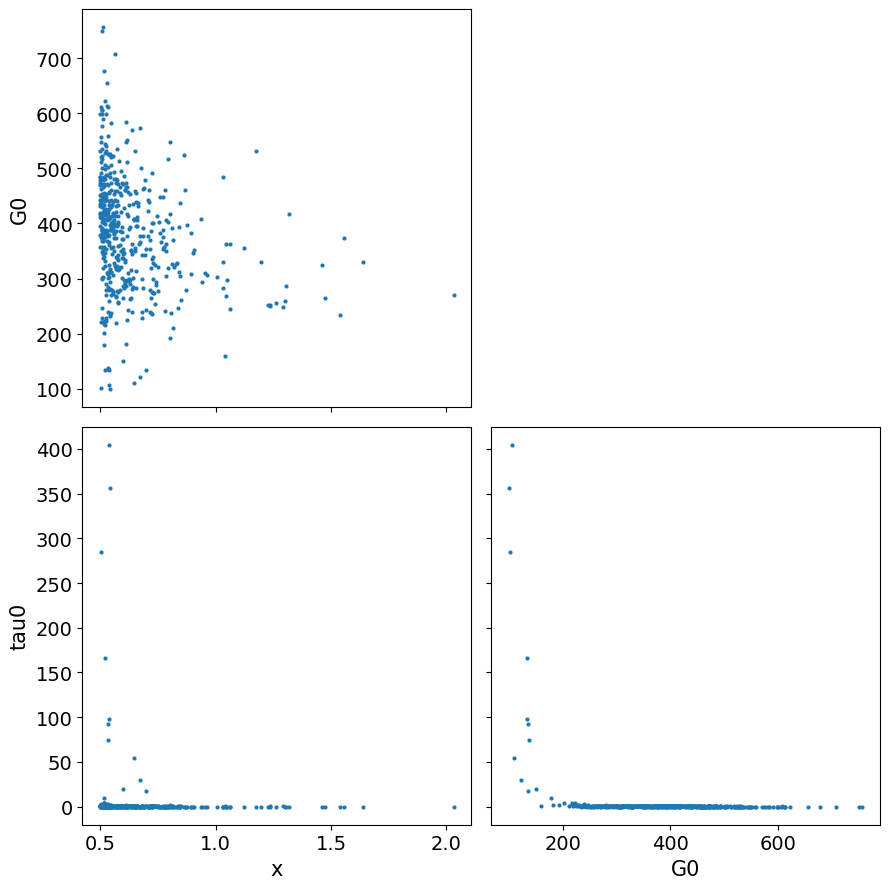

In [14]:
# Pair plot
axes = az.plot_pair(idata, var_names=param_names, kind="scatter", divergences=True, figsize=(9, 9))
fig = axes.ravel()[0].figure
plt.tight_layout()
display(fig)
plt.close(fig)

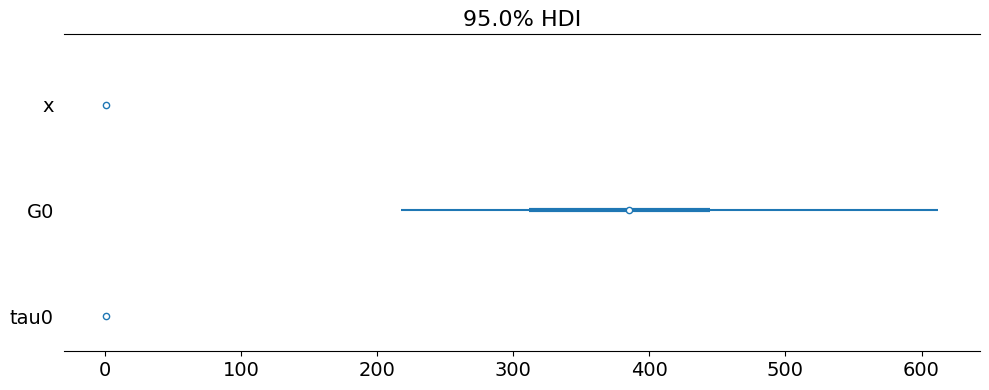

In [15]:
# Forest plot
axes = az.plot_forest(idata, var_names=param_names, combined=True, hdi_prob=0.95, figsize=(10, 4))
fig = axes.ravel()[0].figure
plt.tight_layout()
display(fig)
plt.close(fig)

### 5.4 Posterior Predictive

Generate posterior predictive distributions with 95% credible intervals.

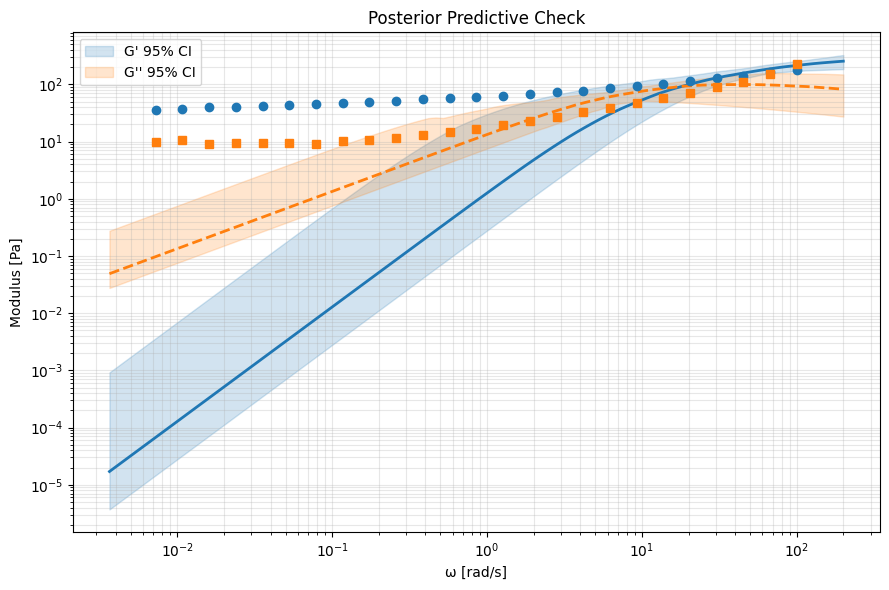

In [16]:
# Posterior predictive with CI bands
posterior = result.posterior_samples
n_draws = min(200, len(list(posterior.values())[0]))
omega_pred = np.logspace(np.log10(omega.min()) - 0.3, np.log10(omega.max()) + 0.3, 100)

pred_Gp = []
pred_Gpp = []
for i in range(n_draws):
    # Set parameters from posterior
    for name in ["x", "G0", "tau0"]:
        model.parameters.set_value(name, float(posterior[name][i]))
    pred_i = model.predict(omega_pred)
    pred_Gp.append(np.array(pred_i[:, 0]))
    pred_Gpp.append(np.array(pred_i[:, 1]))

pred_Gp = np.array(pred_Gp)
pred_Gpp = np.array(pred_Gpp)

fig, ax = plt.subplots(figsize=(9, 6))
ax.fill_between(omega_pred, np.percentile(pred_Gp, 2.5, axis=0), np.percentile(pred_Gp, 97.5, axis=0),
                alpha=0.2, color="C0", label="G' 95% CI")
ax.fill_between(omega_pred, np.percentile(pred_Gpp, 2.5, axis=0), np.percentile(pred_Gpp, 97.5, axis=0),
                alpha=0.2, color="C1", label="G'' 95% CI")
ax.loglog(omega_pred, np.median(pred_Gp, axis=0), "-", lw=2, color="C0")
ax.loglog(omega_pred, np.median(pred_Gpp, axis=0), "--", lw=2, color="C1")
ax.loglog(omega, G_prime, "o", color="C0", markersize=6)
ax.loglog(omega, G_double_prime, "s", color="C1", markersize=6)
ax.set_xlabel("ω [rad/s]")
ax.set_ylabel("Modulus [Pa]")
ax.set_title("Posterior Predictive Check")
ax.legend()
ax.grid(True, alpha=0.3, which="both")
plt.tight_layout()
display(fig)
plt.close(fig)

## 6. Save Results

In [17]:
# Save results
output_dir = os.path.join("..", "outputs", "sgr", "saos")
os.makedirs(output_dir, exist_ok=True)

nlsq_params = {name: float(model.parameters.get_value(name)) for name in ["x", "G0", "tau0"]}
with open(os.path.join(output_dir, "nlsq_params.json"), "w") as f:
    json.dump(nlsq_params, f, indent=2)

posterior_dict = {k: np.array(v).tolist() for k, v in posterior.items()}
with open(os.path.join(output_dir, "posterior_samples.json"), "w") as f:
    json.dump(posterior_dict, f)

print(f"Results saved to {output_dir}/")

Results saved to ../outputs/sgr/saos/


## Key Takeaways

1. **Power-law scaling:** SGR predicts $G' \sim G'' \sim \omega^{x-1}$ — the slope directly encodes the noise temperature x
2. **Phase classification:** The phase regime is visible in the G' vs G'' ordering (glass: G' >> G'', Newtonian: G'' >> G')
3. **Soft glassy materials:** The chia seed gel is a soft glassy material with x in the power-law regime (1 < x < 2)
4. **Cole-Cole plots:** Provide a phase-space view of the viscoelastic response, revealing material structure
5. **GENERIC framework:** SGRGeneric matches SGRConventional for oscillation with thermodynamic consistency guarantees

**Next steps:** Explore creep (NB 04) or flow curves (NB 01) for different protocol views of SGR behavior.